In [329]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install numpy
#
# !pip install seaborn

In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [331]:
week_days_path = "./paris_weekdays.csv"
week_ends_path = "./paris_weekends.csv"

paris_weekdays = pd.read_csv(week_days_path, index_col=0)
paris_weekends = pd.read_csv(week_ends_path, index_col=0)

paris_weekdays['is_weekend'] = 0
paris_weekends['is_weekend'] = 1

paris_all = pd.concat([paris_weekdays, paris_weekends], ignore_index=True)

print("Shape of combined dataset:", paris_all.shape)
print("Missing values:\n", paris_all.isnull().sum())


Shape of combined dataset: (6688, 20)
Missing values:
 realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


In [332]:
print(paris_all.head())

      realSum        room_type  room_shared  room_private  person_capacity  \
0  296.159940     Private room        False          True              2.0   
1  288.237487     Private room        False          True              2.0   
2  211.343089     Private room        False          True              2.0   
3  298.956100  Entire home/apt        False         False              2.0   
4  247.926181  Entire home/apt        False         False              4.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0               True      0    0                10.0   
1               True      0    0                10.0   
2              False      0    0                10.0   
3              False      0    1                 9.0   
4              False      0    0                 7.0   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                        97.0         1  0.699821    0.193709  518.478947   
1                        97.0         1 

In [333]:
paris_all.shape

(6688, 20)

# Missing values

In [334]:
print(paris_all.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


In [335]:
print(paris_all.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


No missing values??? :)

# Standaryzacja

In [336]:
selected_columns = [
    'guest_satisfaction_overall',
    'dist',
    'realSum'
]

In [337]:
def remove_outliers(data, columns):
    filtered_data = data.copy()
    outlier_mask = pd.Series([True] * len(filtered_data))

    for col in columns:
        Q1 = filtered_data[col].quantile(0.25)
        Q3 = filtered_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        outlier_mask &= (filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)

    filtered_data = filtered_data[outlier_mask]
    removed_count = len(data) - len(filtered_data)
    print(f"Removed {removed_count} outliers ({removed_count/len(data)*100:.2f}%)")
    print(f"Remaining data: {len(filtered_data)} rows")

    return filtered_data

paris_all_clean = remove_outliers(paris_all, selected_columns)

Removed 232 outliers (3.47%)
Remaining data: 6456 rows


Combined dataset after standardization:
       guest_satisfaction_overall          dist       realSum
count                6.456000e+03  6.456000e+03  6.456000e+03
mean                 7.946280e-16  1.760949e-16 -3.257755e-16
std                  1.000077e+00  1.000077e+00  1.000077e+00
min                 -4.279622e+00 -2.005350e+00 -1.478276e+00
25%                 -5.252568e-01 -7.974754e-01 -6.939185e-01
50%                  1.967365e-01  2.481564e-03 -2.846883e-01
75%                  7.743311e-01  7.220513e-01  4.377798e-01
max                  1.063128e+00  3.227402e+00  4.113273e+00


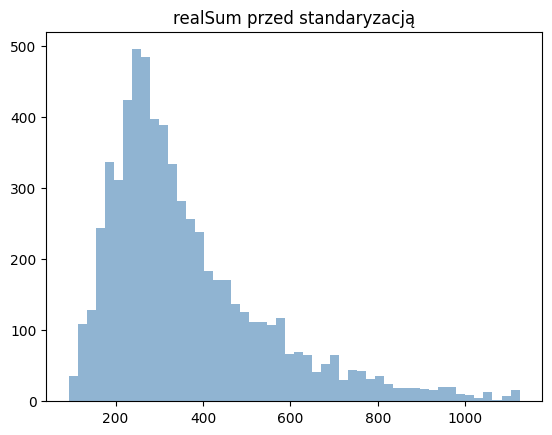

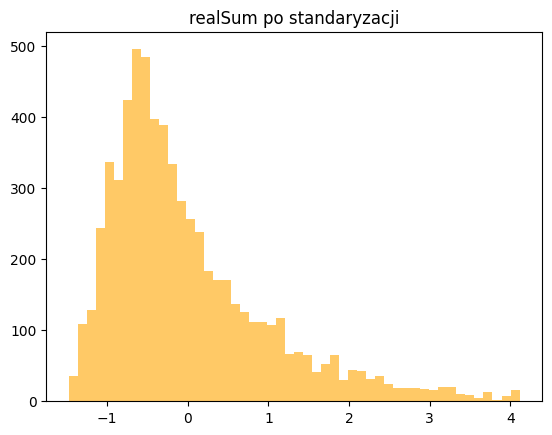

In [338]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
paris_all_std = paris_all_clean.copy()
paris_all_std[selected_columns] = scaler.fit_transform(paris_all_clean[selected_columns])

print("Combined dataset after standardization:")
print(paris_all_std[selected_columns].describe())

plt.hist(paris_all_clean['realSum'], bins=50, alpha=0.6, color='steelblue')
plt.title("realSum przed standaryzacją")
plt.show()

plt.hist(paris_all_std['realSum'], bins=50, alpha=0.6, color='orange')
plt.title("realSum po standaryzacji")
plt.show()

# Korelacja

In [339]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def analyze_correlations_with_outlier_filter(df, selected_columns):
    target = 'realSum'
    variables = [c for c in selected_columns if c != target]

    print(f"\nCorrelation Analysis for Combined Dataset")

    correlations = {}
    for var in variables:
        corr = df[target].corr(df[var])
        correlations[var] = corr
        print(f"{target} vs {var:30} : {corr:+.4f}")

    realSum_threshold = df[target].quantile(0.95)
    df_filtered_all = df[df[target] <= realSum_threshold].copy()

    fig, axes = plt.subplots(1, len(variables), figsize=(7 * len(variables), 5))
    if len(variables) == 1:
        axes = [axes]

    for idx, var in enumerate(variables):
        ax = axes[idx]

        var_threshold = df_filtered_all[var].quantile(0.95)
        df_filtered = df_filtered_all[df_filtered_all[var] <= var_threshold].copy()

        sns.scatterplot(
            data=df_filtered,
            x=var,
            y=target,
            alpha=0.6,
            s=40,
            ax=ax
        )

        ax.set_xlabel(var, fontsize=11, fontweight='bold')
        ax.set_ylabel(target, fontsize=11, fontweight='bold')

        corr_val = correlations[var]
        ax.text(
            0.05, 0.95,
            f'r = {corr_val:+.3f}',
            transform=ax.transAxes,
            fontsize=12,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
        )

        ax.grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(
        f'Correlation Analysis: Combined Dataset\n(Filtered: top 5% outliers removed)',
        fontsize=15,
        fontweight='bold',
        y=1.05
    )
    plt.tight_layout()
    plt.show()

    return correlations


Correlation Analysis for Combined Dataset
realSum vs guest_satisfaction_overall     : +0.0728
realSum vs dist                           : -0.2078


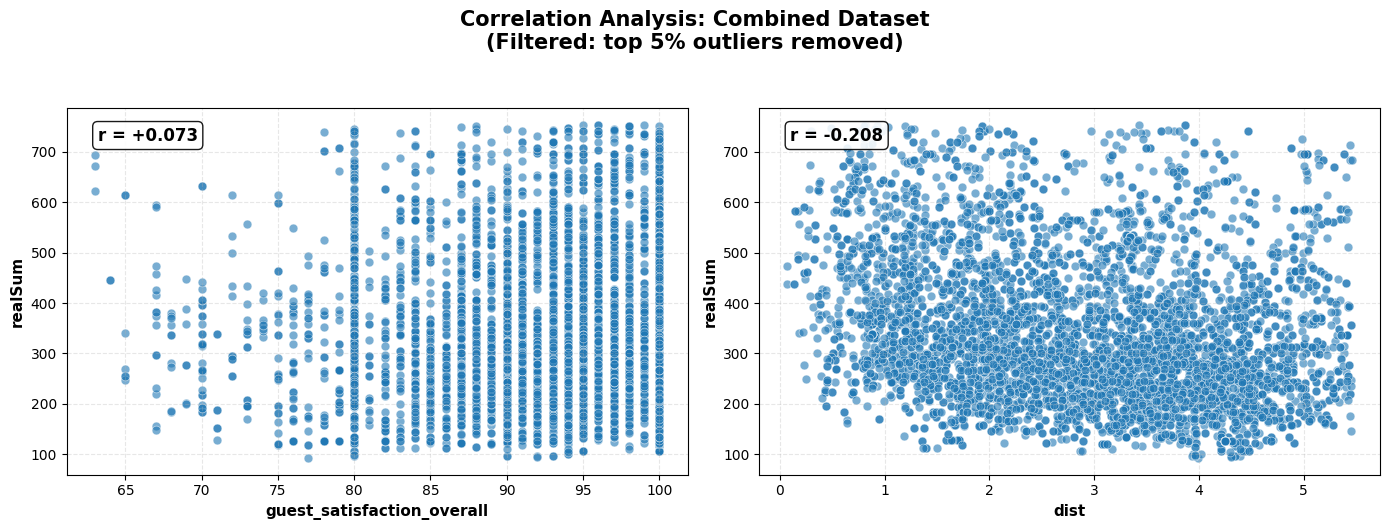

In [340]:

correlations_all = analyze_correlations_with_outlier_filter(paris_all_clean, selected_columns)

corr_val: 0.06429768149711612
corr_val: 0.053586738000523236
corr_val: 0.045665694708080934


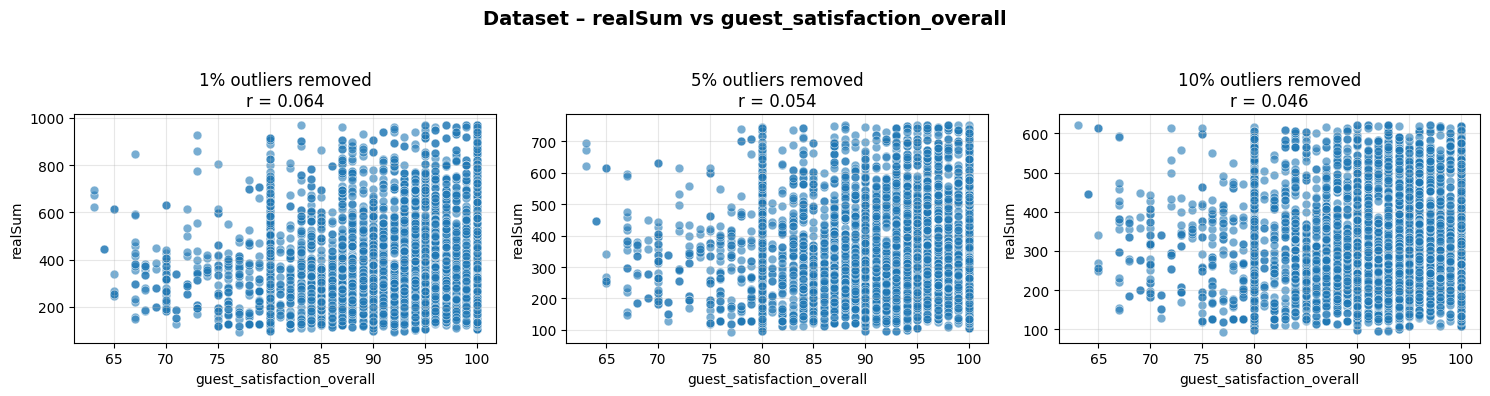

corr_val: -0.22469959661455347
corr_val: -0.2330552429250891
corr_val: -0.28678643146352095


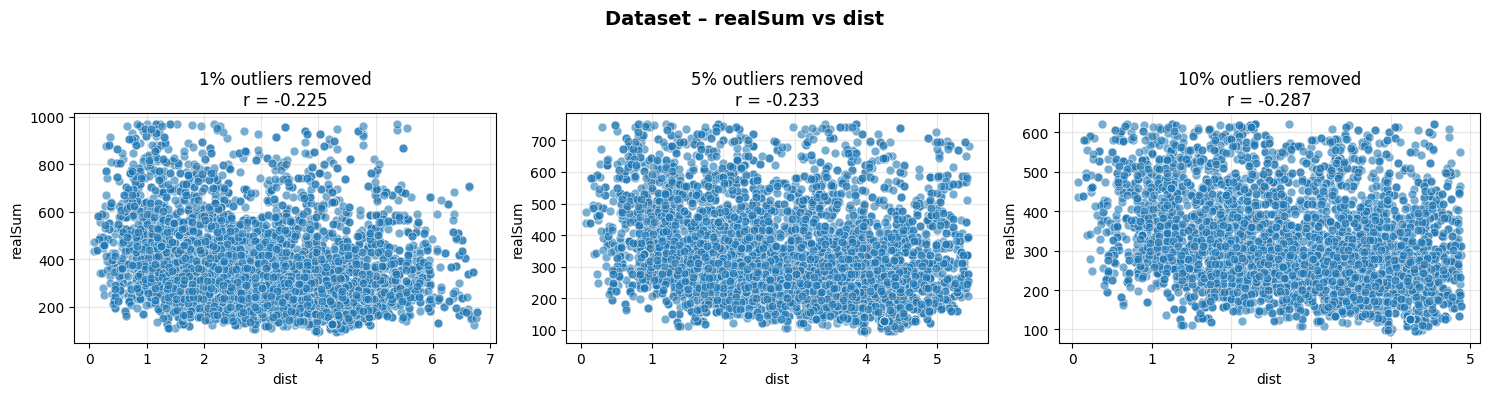

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multiple_correlations(df, selected_columns, outlier_percents=[0.01, 0.05, 0.10], dataset_name="Dataset"):
    """
    Tworzy wykresy korelacji realSum vs inne zmienne z różnym % odrzuconych outlierów.
    df: DataFrame
    selected_columns: lista kolumn do analizy, musi zawierać 'realSum'
    outlier_percents: lista % próbek do odrzucenia
    dataset_name: nazwa zestawu danych (weekdays/weekends)
    """
    target = 'realSum'
    variables = [c for c in selected_columns if c != target]

    for var in variables:
        plt.figure(figsize=(15, 4))
        for idx, perc in enumerate(outlier_percents, 1):
            x_thresh = df[var].quantile(1 - perc)
            y_thresh = df[target].quantile(1 - perc)
            df_filtered = df[(df[var] <= x_thresh) & (df[target] <= y_thresh)]
            
            corr_val = df_filtered[var].corr(df_filtered[target])
            print('corr_val:', corr_val)
            
            plt.subplot(1, len(outlier_percents), idx)
            sns.scatterplot(data=df_filtered, x=var, y=target, alpha=0.6, s=40)
            plt.title(f'{perc*100:.0f}% outliers removed\nr = {corr_val:.3f}')
            plt.xlabel(var)
            plt.ylabel(target)
            plt.grid(True, alpha=0.3)
        
        plt.suptitle(f'{dataset_name} – {target} vs {var}', fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_multiple_correlations(paris_all_clean, selected_columns, outlier_percents=[0.01, 0.05, 0.10])

Wnioski

realSum vs guest_satisfaction_overall
- Korelacja praktycznie zerowa, niezależnie od odrzucenia 1%, 5% czy 10% próbek.
- Ceny hoteli nie są istotnie związane z ocenami satysfakcji gości.
- Najlepszy % odrzuconych outlierów: 5% – kompromis między zachowaniem większości danych a stabilnością korelacji.

realSum vs dist
- Słaba do umiarkowanej korelacja ujemna, która rośnie przy usunięciu większej liczby outlierów.
- Im bliżej centrum, tym cena obiektu wzrasta. Wzrost % odrzuconych outlierów lekko wzmacnia korelację, co pokazuje wpływ skrajnych wartości.
- Najlepszy % odrzuconych outlierów: 5% – kompromis między zachowaniem większości danych a stabilnością korelacji.

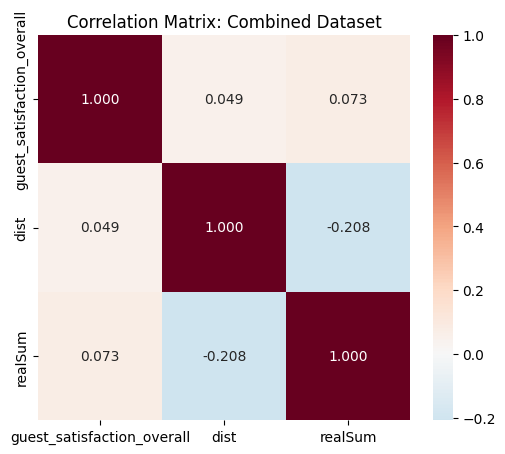

In [342]:
plt.figure(figsize=(6,5))
sns.heatmap(paris_all_clean[selected_columns].corr(), annot=True, fmt=".3f", cmap='RdBu_r', center=0)
plt.title("Correlation Matrix: Combined Dataset")
plt.show()

# Estymator jadrowy

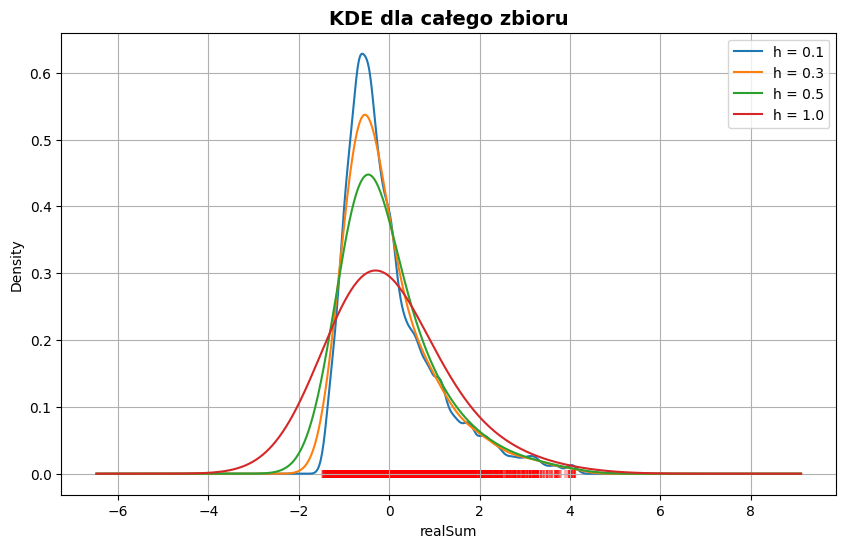

In [343]:
import numpy as np
import matplotlib.pyplot as plt
import math

def K(x):
    return 1 / (math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)

def kde(x_all, x, h):
    m = len(x_all)
    sum_k = sum(K((x - xi) / h) for xi in x_all)
    return sum_k / (m * h)

def plot_kde_with_bandwidths(data, h_values, title):
    x_min, x_max = data.min() - 5, data.max() + 5
    x_plot = np.linspace(x_min, x_max, 1000)
    
    plt.figure(figsize=(10,6))
    
    for h in h_values:
        y_plot = [kde(data, xi, h) for xi in x_plot]
        plt.plot(x_plot, y_plot, label=f'h = {h}')
    
    plt.scatter(data, np.zeros_like(data), color='red', alpha=0.3, marker='|')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('realSum')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

h_values = [0.1, 0.3, 0.5, 1.0]
plot_kde_with_bandwidths(paris_all_std['realSum'].values, h_values, "KDE dla całego zbioru")

# Outlier analysis

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from numpy.linalg import inv

def get_outlier_rows(df, col, z_thresh=3):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[np.abs(z_scores) > z_thresh]

def mahalanobis_outliers(df, cols, threshold=0.99):
    data = df[cols].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = inv(cov)
    diff = data - mean
    m_dist = np.sqrt(np.sum(diff @ inv_covmat * diff, axis=1))
    
    critical_value = np.sqrt(chi2.ppf(threshold, df=len(cols)))
    outlier_mask = m_dist > critical_value
    return df[outlier_mask], m_dist

def plot_distribution_with_outliers(df, col):
    plt.figure(figsize=(8,4))
    plt.hist(df[col], bins=50, alpha=0.7, color='steelblue')
    outliers = get_outlier_rows(df, col)
    if len(outliers) > 0:
        plt.scatter(outliers[col], [0]*len(outliers), color='red', label='Outliers', zorder=10)
    plt.title(f'Distribution with Outliers: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return df[col].describe()


Analyzing column: guest_satisfaction_overall
Found 85 outlier rows
     guest_satisfaction_overall      dist     realSum
72                         65.0  0.187260  340.432473
78                         69.0  0.800433  448.317644
102                        68.0  1.105269  355.578339
163                        71.0  0.883245  339.500419
338                        70.0  1.228140  183.148476


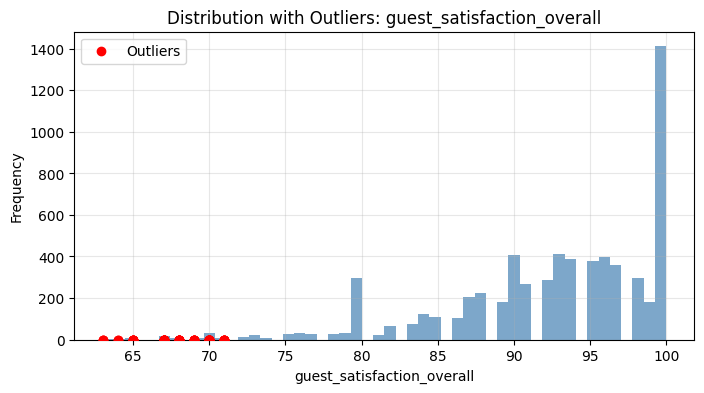


Analyzing column: dist
Found 15 outlier rows
      guest_satisfaction_overall      dist     realSum
2467                        86.0  7.557054  248.392208
2468                       100.0  7.398353  253.518501
2586                        94.0  7.474171  354.646286
2597                        95.0  7.679992  695.544785
2600                        87.0  7.703737  463.696523


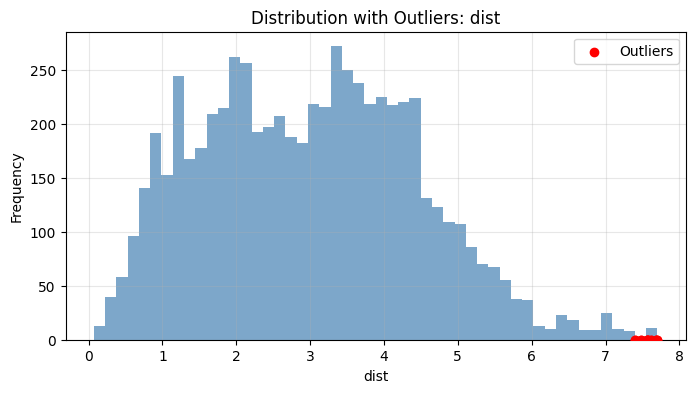


Analyzing column: realSum
Found 119 outlier rows
    guest_satisfaction_overall      dist     realSum
27                        97.0  1.004781  968.403393
28                        97.0  1.160891  968.403393
57                        95.0  1.164846  921.101687
67                        96.0  3.275414  973.762699
85                       100.0  1.398949  970.966539


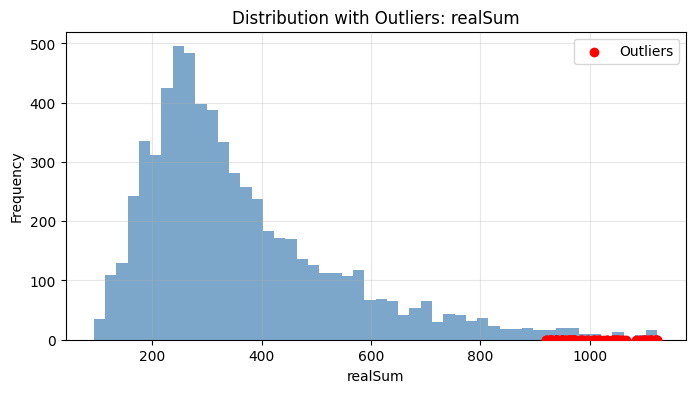

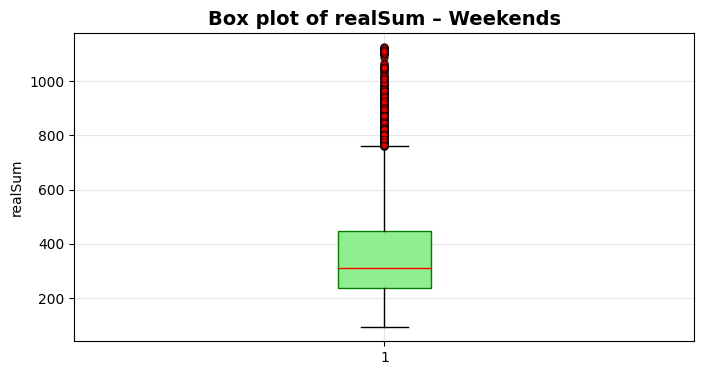


Multivariate Outlier Analysis: realSum vs dist
Number of outliers: 164 / 6456 (2.54%)


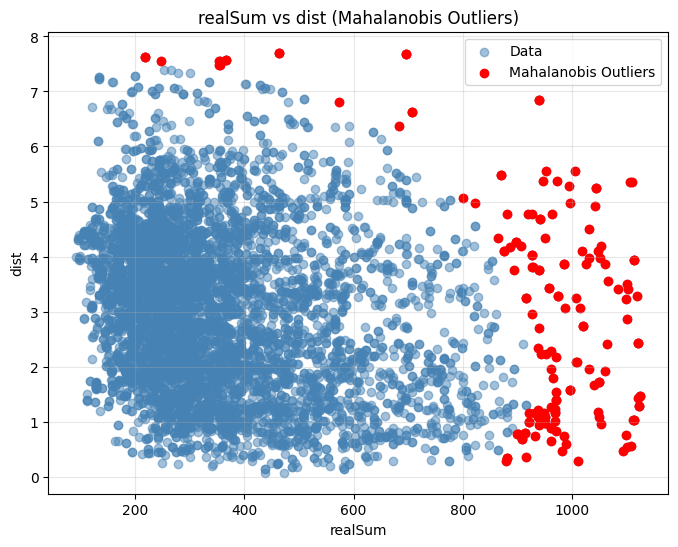


Multivariate Outlier Analysis: realSum vs guest_satisfaction_overall
Number of outliers: 226 / 6456 (3.50%)


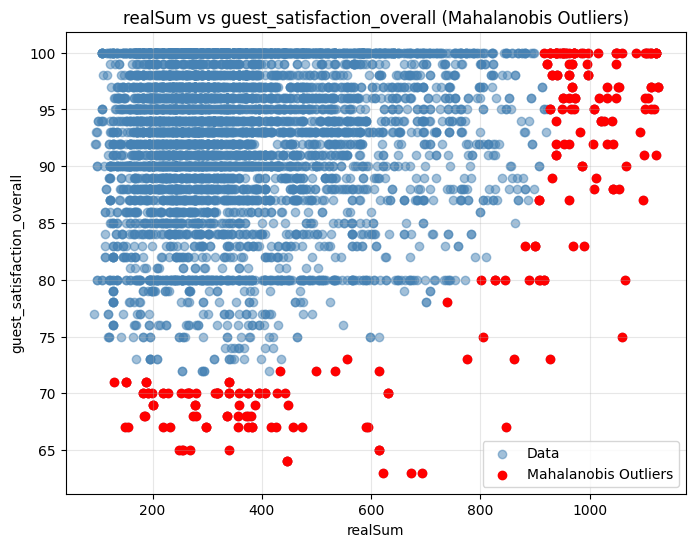

In [345]:
for col in selected_columns:
    print(f"\n{'='*40}\nAnalyzing column: {col}\n{'='*40}")
    outliers = get_outlier_rows(paris_all_clean, col)
    print(f"Found {len(outliers)} outlier rows")
    if len(outliers) > 0:
        print(outliers[selected_columns].head())
    plot_distribution_with_outliers(paris_all_clean, col)

plt.figure(figsize=(8,4))
plt.boxplot(paris_all_clean['realSum'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.6))
plt.title('Box plot of realSum – Weekends', fontsize=14, fontweight='bold')
plt.ylabel('realSum')
plt.grid(True, alpha=0.3)
plt.show()

pairs = [
    ('realSum', 'dist'),
    ('realSum', 'guest_satisfaction_overall')
]

for x_var, y_var in pairs:
    print(f"\n{'='*60}")
    print(f"Multivariate Outlier Analysis: {x_var} vs {y_var}")
    print(f"{'='*60}")
    
    outliers, m_dist = mahalanobis_outliers(paris_all_clean, [x_var, y_var], threshold=0.99)
    print(f"Number of outliers: {len(outliers)} / {len(paris_all_clean)} ({len(outliers)/len(paris_all_clean)*100:.2f}%)")
    
    plt.figure(figsize=(8,6))
    plt.scatter(paris_all_clean[x_var], paris_all_clean[y_var], c='steelblue', alpha=0.5, label='Data')
    plt.scatter(outliers[x_var], outliers[y_var], c='red', label='Mahalanobis Outliers')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f"{x_var} vs {y_var} (Mahalanobis Outliers)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

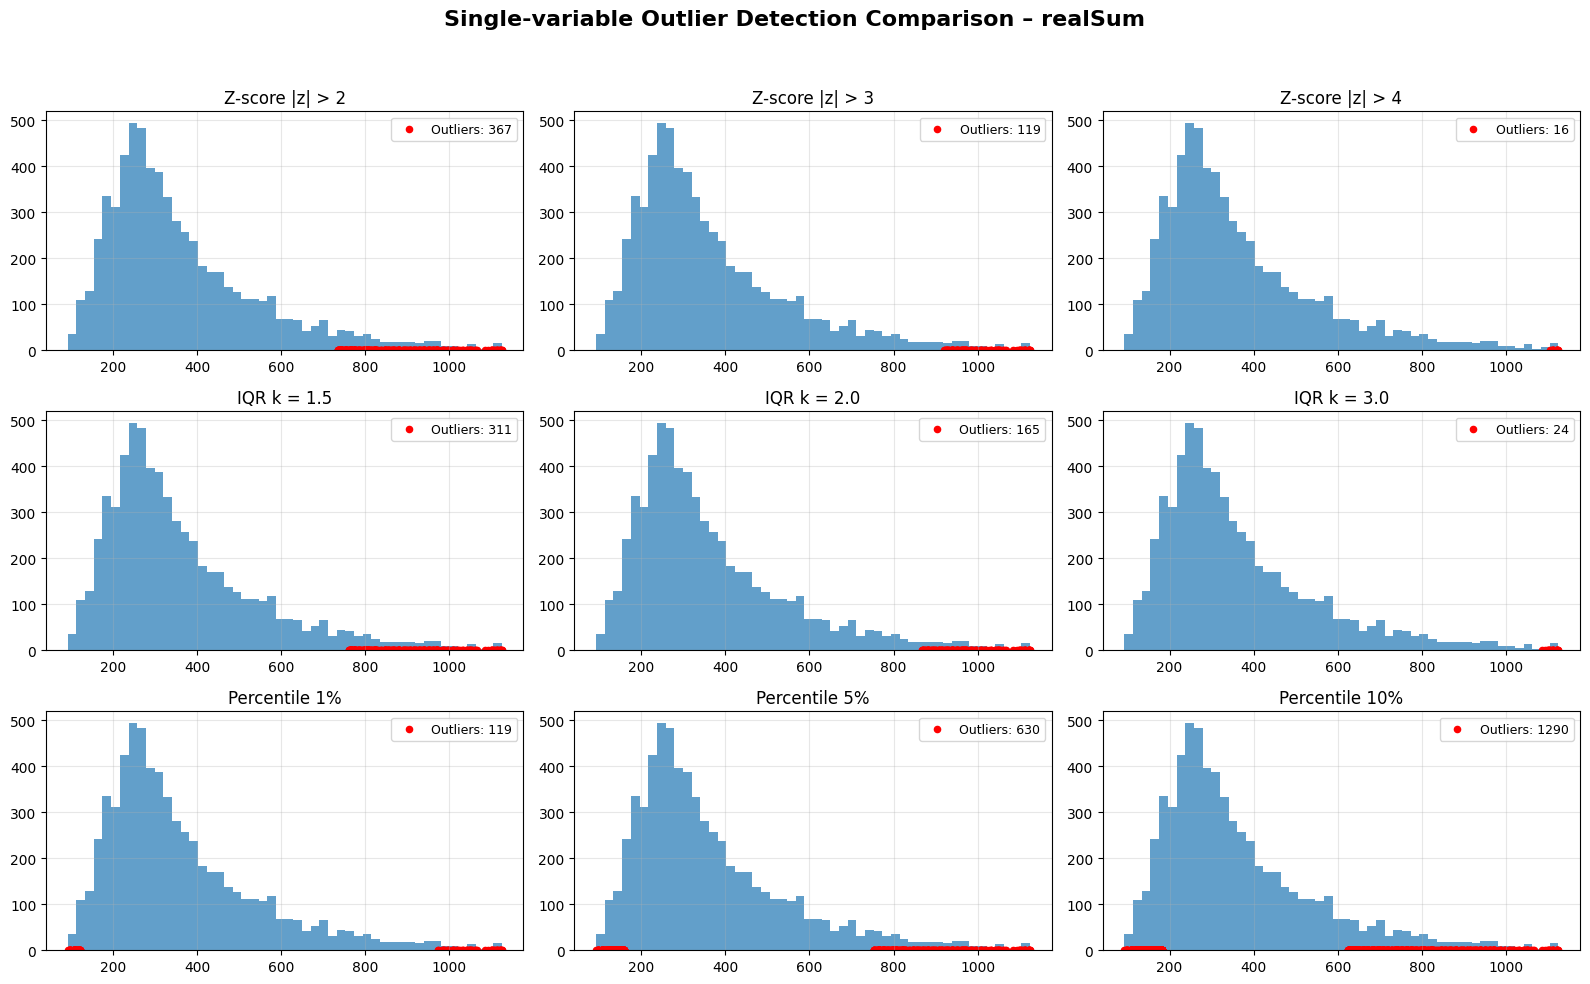

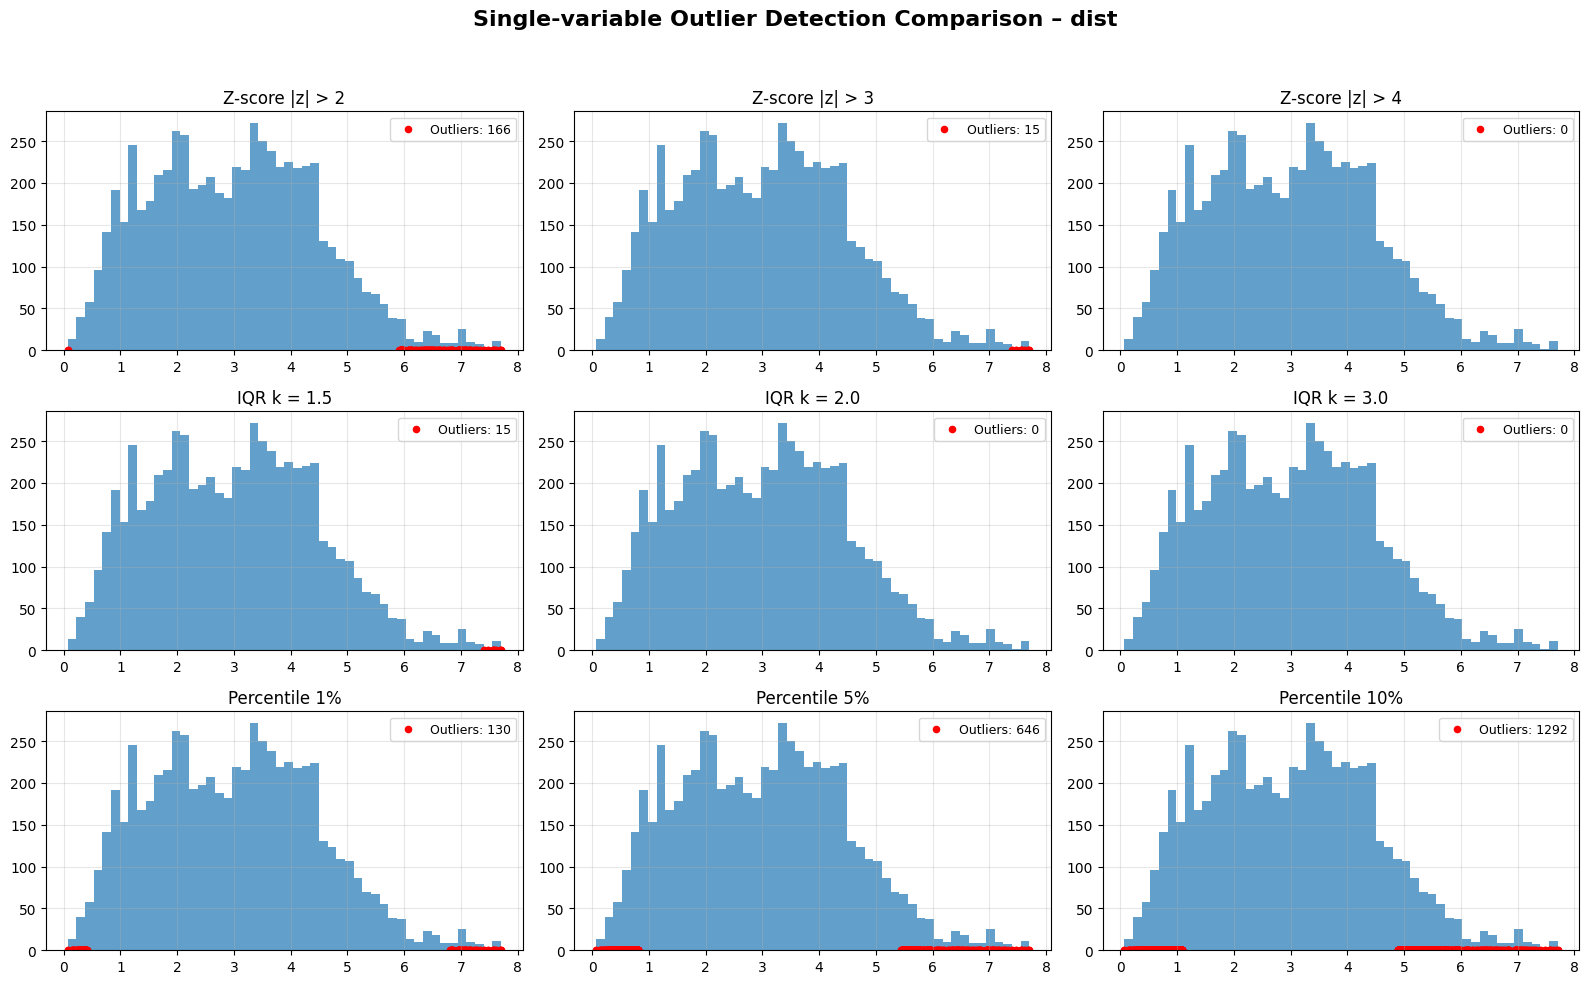

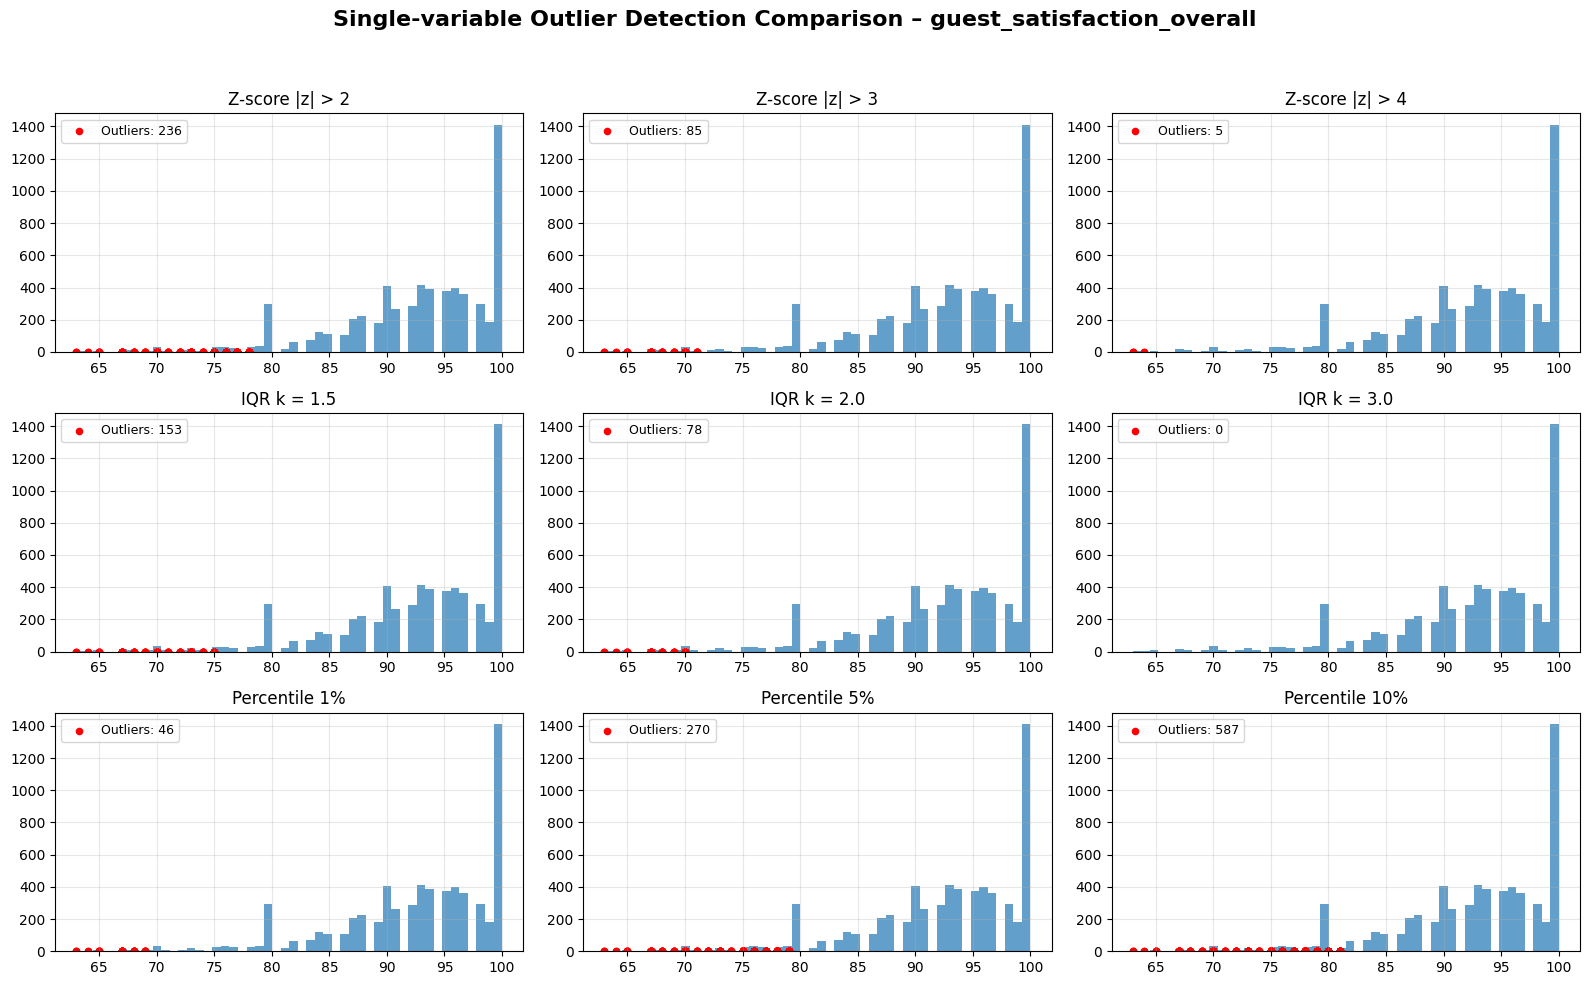

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def zscore_outliers(series, threshold):
    z = (series - series.mean()) / series.std()
    return np.abs(z) > threshold

def iqr_outliers(series, k):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series < lower) | (series > upper)

def percentile_outliers(series, perc):
    lower = series.quantile(perc)
    upper = series.quantile(1 - perc)
    return (series < lower) | (series > upper)

def compare_outlier_methods(series, variable_name):
    methods = [
        ("Z-score |z| > 2", zscore_outliers(series, 2)),
        ("Z-score |z| > 3", zscore_outliers(series, 3)),
        ("Z-score |z| > 4", zscore_outliers(series, 4)),
        ("IQR k = 1.5", iqr_outliers(series, 1.5)),
        ("IQR k = 2.0", iqr_outliers(series, 2.0)),
        ("IQR k = 3.0", iqr_outliers(series, 3.0)),
        ("Percentile 1%", percentile_outliers(series, 0.01)),
        ("Percentile 5%", percentile_outliers(series, 0.05)),
        ("Percentile 10%", percentile_outliers(series, 0.10)),
    ]

    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    axes = axes.flatten()

    for ax, (title, mask) in zip(axes, methods):
        ax.hist(series, bins=50, alpha=0.7)
        ax.scatter(
            series[mask],
            np.zeros(mask.sum()),
            color='red',
            s=20,
            label=f'Outliers: {mask.sum()}'
        )
        ax.set_title(title)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"Single-variable Outlier Detection Comparison – {variable_name}",
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

compare_outlier_methods(paris_all_clean['realSum'], 'realSum')
compare_outlier_methods(paris_all_clean['dist'], 'dist')
compare_outlier_methods(paris_all_clean['guest_satisfaction_overall'], 'guest_satisfaction_overall')

# Klasyfikacja

Classification Results:
Accuracy: 0.5271

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.05      0.08       618
           1       0.53      0.97      0.68       674

    accuracy                           0.53      1292
   macro avg       0.55      0.51      0.38      1292
weighted avg       0.55      0.53      0.40      1292

Confusion Matrix:
[[ 28 590]
 [ 21 653]]

Feature Importance (Logistic Regression Coefficients):
                   feature  coefficient
guest_satisfaction_overall     0.049460
                      dist    -0.045168
                   realSum    -0.044372


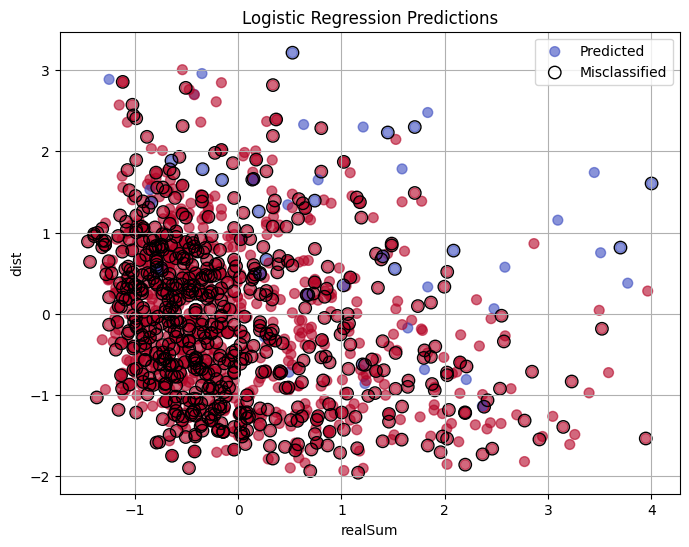

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['is_weekend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
coefficients['abs_coef'] = np.abs(coefficients['coefficient'])
coefficients = coefficients.sort_values('abs_coef', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(coefficients[['feature', 'coefficient']].to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_pred_plot,
    cmap='coolwarm',
    alpha=0.6,
    s=50,
    label='Predicted'
)

misclassified = y_pred_plot != y_true
plt.scatter(
    X_plot[misclassified, 0], X_plot[misclassified, 1],
    facecolors='none',
    edgecolors='black',
    s=80,
    label='Misclassified'
)

plt.xlabel('realSum')
plt.ylabel('dist')
plt.title('Logistic Regression Predictions')
plt.legend()
plt.grid(True)
plt.show()


Classification Results:
Accuracy: 0.5163

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.06      0.11       618
           1       0.52      0.93      0.67       674

    accuracy                           0.52      1292
   macro avg       0.49      0.50      0.39      1292
weighted avg       0.49      0.52      0.40      1292

Confusion Matrix:
[[ 38 580]
 [ 45 629]]

Feature Importance (Decision Tree):
                   feature  importance
                   realSum    0.599179
                      dist    0.349843
guest_satisfaction_overall    0.050978


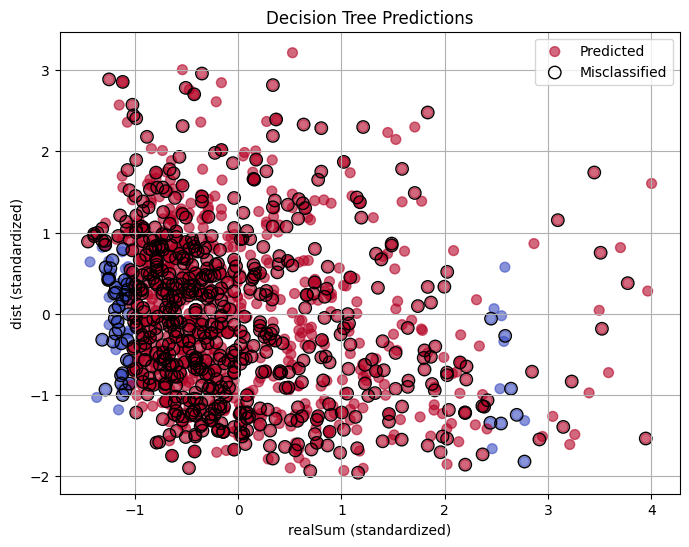

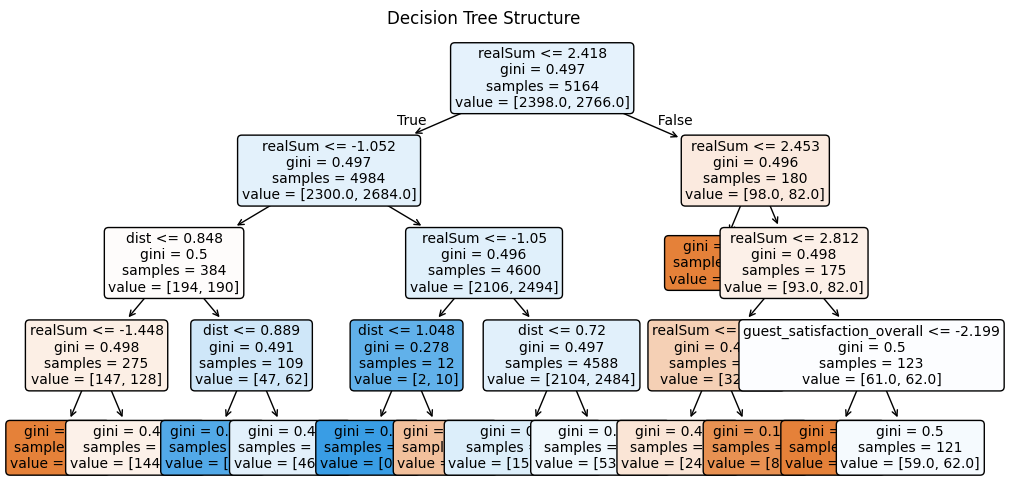

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = paris_all_clean[['realSum', 'dist', 'guest_satisfaction_overall']]
y = paris_all_clean['is_weekend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print("Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance.to_string(index=False))

plt.figure(figsize=(8,6))

X_plot = X_test_scaled[:, :2]
y_true = y_test.values
y_pred_plot = y_pred

plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_pred_plot,
    cmap='coolwarm',
    alpha=0.6,
    s=50,
    label='Predicted'
)

misclassified = y_pred_plot != y_true
plt.scatter(
    X_plot[misclassified, 0], X_plot[misclassified, 1],
    facecolors='none',
    edgecolors='black',
    s=80,
    label='Misclassified'
)

plt.xlabel('realSum (standardized)')
plt.ylabel('dist (standardized)')
plt.title('Decision Tree Predictions')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns,
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()


Wniosek:
Co było widoczne już na etapie korelacji – nie ma większej różnicy między weekday a weekend, zatem nie jest możliwe skuteczne rozróżnienie tych klas na podstawie użytych cech. Model przewiduje głównie dominantną klasę, co skutkuje wysokim recall dla weekendów i słabym dla dni roboczych.

# Klasteryzacja

In [349]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_clustering(data, n_clusters):
    if 'is_weekend' in data.columns:
        X = data[selected_columns].copy()
    else:
        X = data[selected_columns].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    return labels, kmeans, scaler

In [350]:
labels_2, kmeans_2, scaler_2 = perform_clustering(paris_all_clean, n_clusters=2)
paris_all_clean['cluster_2'] = labels_2

labels_3, kmeans_3, scaler_3 = perform_clustering(paris_all_clean, n_clusters=3)
paris_all_clean['cluster_3'] = labels_3

print("\n=== 2 Clusters ===")
print(paris_all_clean.groupby('cluster_2')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_2'].value_counts().to_dict()}")

print("\n=== 3 Clusters ===")
print(paris_all_clean.groupby('cluster_3')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")


=== 2 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_2                                                              
0          459.192525  1.835267                   92.041377    0.535915
1          283.019345  4.017650                   93.161863    0.530131

Cluster sizes: {1: 3435, 0: 3021}

=== 3 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_3                                                              
0          527.267495  1.861705                   95.526108    0.533005
1          279.772382  3.904626                   95.340342    0.535808
2          316.506455  2.662827                   82.441389    0.526049

Cluster sizes: {1: 3044, 0: 2030, 2: 1382}


In [351]:
def visualize_clusters(data, cluster_column, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[0].scatter(
            cluster_data['realSum'],
            cluster_data['dist'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[0].set_xlabel('Price (realSum)')
    axes[0].set_ylabel('Distance')
    axes[0].set_title('Price vs Distance')
    axes[0].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[1].scatter(
            cluster_data['realSum'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[1].set_xlabel('Price (realSum)')
    axes[1].set_ylabel('Guest Satisfaction')
    axes[1].set_title('Price vs Satisfaction')
    axes[1].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[2].scatter(
            cluster_data['dist'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('Guest Satisfaction')
    axes[2].set_title('Distance vs Satisfaction')
    axes[2].legend()

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [352]:
labels_2, kmeans_2, scaler_2 = perform_clustering(paris_all_clean, n_clusters=2)
paris_all_clean['cluster_2'] = labels_2

labels_3, kmeans_3, scaler_3 = perform_clustering(paris_all_clean, n_clusters=3)
paris_all_clean['cluster_3'] = labels_3

print("=== 2 Clusters ===")
print(paris_all_clean.groupby('cluster_2')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_2'].value_counts().to_dict()}")

print("\n=== 3 Clusters ===")
print(paris_all_clean.groupby('cluster_3')[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")

=== 2 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_2                                                              
0          459.192525  1.835267                   92.041377    0.535915
1          283.019345  4.017650                   93.161863    0.530131

Cluster sizes: {1: 3435, 0: 3021}

=== 3 Clusters ===
              realSum      dist  guest_satisfaction_overall  is_weekend
cluster_3                                                              
0          527.267495  1.861705                   95.526108    0.533005
1          279.772382  3.904626                   95.340342    0.535808
2          316.506455  2.662827                   82.441389    0.526049

Cluster sizes: {1: 3044, 0: 2030, 2: 1382}


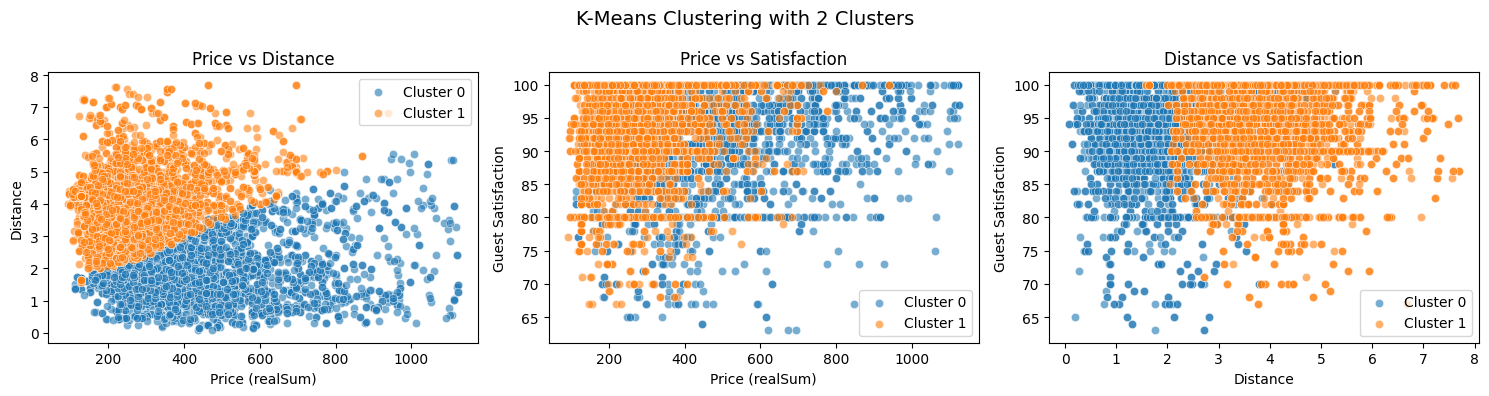

In [353]:
visualize_clusters(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters')

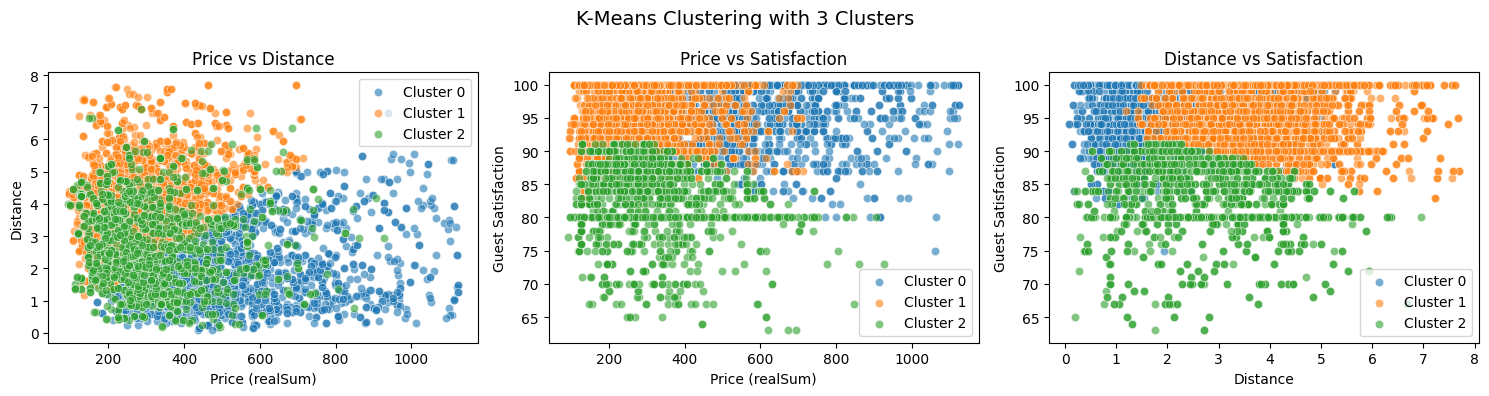

In [354]:
visualize_clusters(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters')

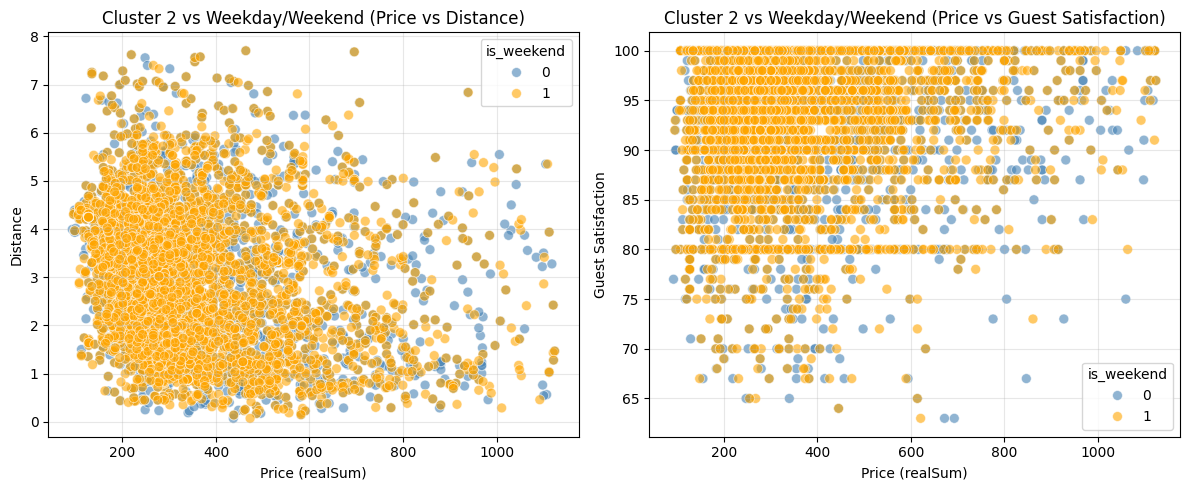

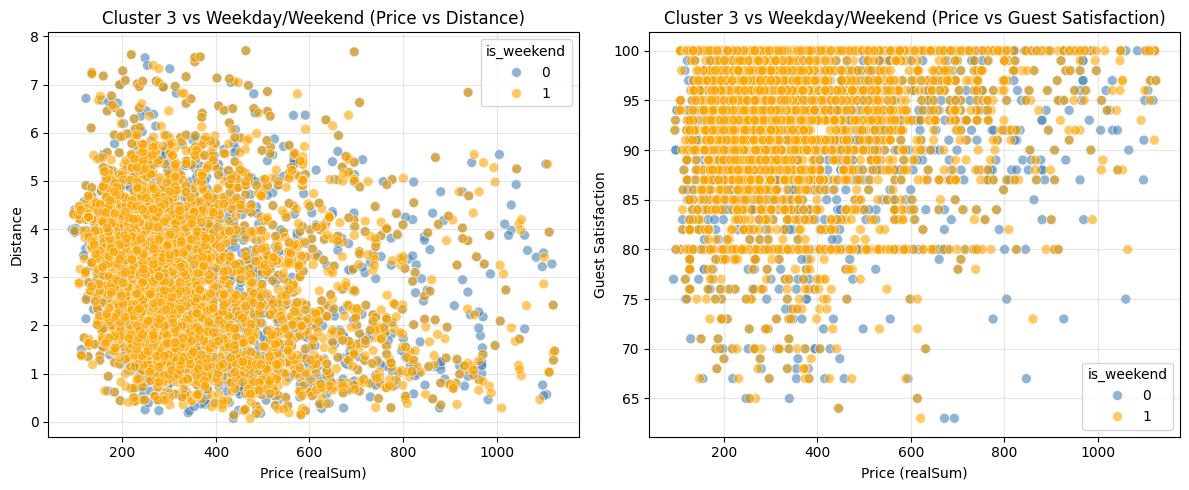

In [355]:
def visualize_clusters_vs_weekend(data, cluster_column='cluster_2', title="Clusters vs Weekday/Weekend"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.scatterplot(
        data=data,
        x='realSum',
        y='dist',
        hue='is_weekend',
        palette={0:'steelblue', 1:'orange'},
        alpha=0.6,
        edgecolor='white',
        s=50
    )
    plt.title(f'{title} (Price vs Distance)')
    plt.xlabel('Price (realSum)')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1,2,2)
    sns.scatterplot(
        data=data,
        x='realSum',
        y='guest_satisfaction_overall',
        hue='is_weekend',
        palette={0:'steelblue', 1:'orange'},
        alpha=0.6,
        edgecolor='white',
        s=50
    )
    plt.title(f'{title} (Price vs Guest Satisfaction)')
    plt.xlabel('Price (realSum)')
    plt.ylabel('Guest Satisfaction')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_clusters_vs_weekend(paris_all_clean, cluster_column='cluster_2', title="Cluster 2 vs Weekday/Weekend")

visualize_clusters_vs_weekend(paris_all_clean, cluster_column='cluster_3', title="Cluster 3 vs Weekday/Weekend")


In [356]:
def visualize_clusters_3d(data, cluster_column, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        ax.scatter(
            cluster_data['realSum'],
            cluster_data['dist'],
            cluster_data['guest_satisfaction_overall'],
            label=f'Cluster {cluster}',
            alpha=0.6,
            s=30,
            edgecolors='white',
            linewidth=0.5
        )

    ax.set_xlabel('Price (realSum)')
    ax.set_ylabel('Distance')
    ax.set_zlabel('Guest Satisfaction')
    ax.set_title(title)
    ax.legend(loc='upper left', framealpha=0.9)

    plt.tight_layout()
    plt.show()

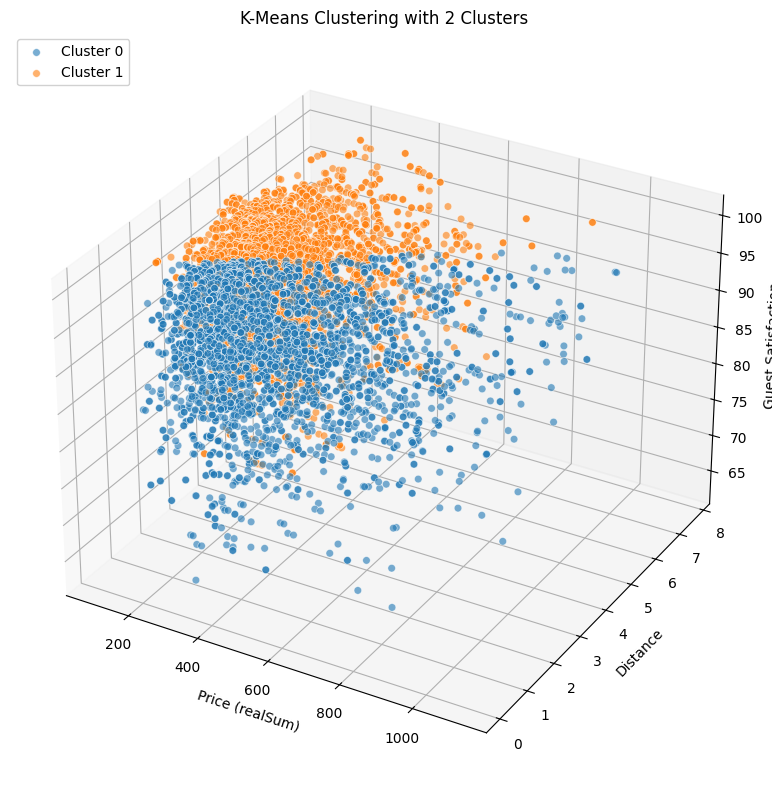

In [357]:
visualize_clusters_3d(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters')

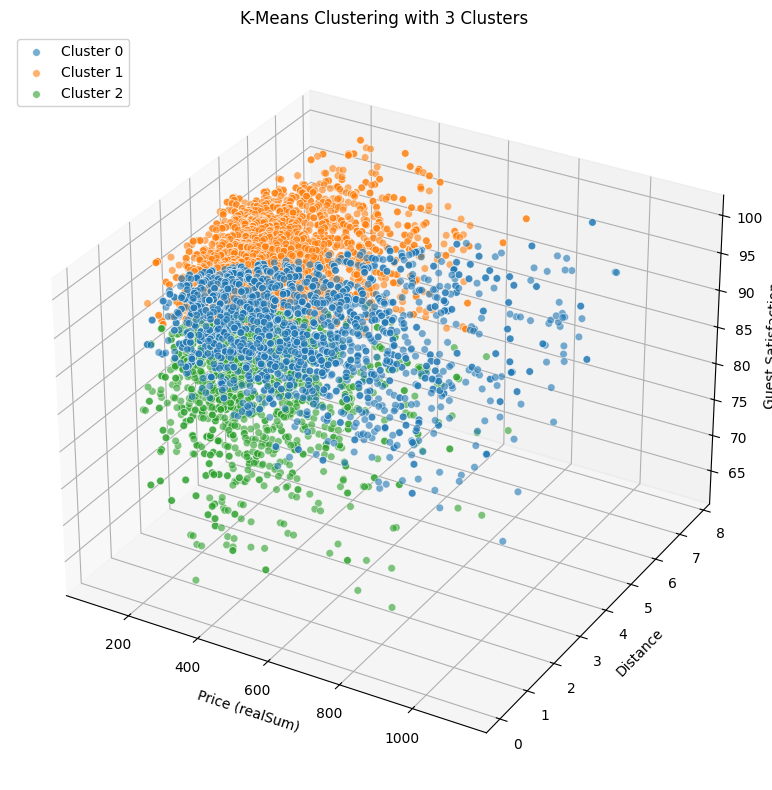

In [358]:
visualize_clusters_3d(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters')

# Klasteryzacja - osobno

In [359]:
labels_2_all, kmeans_2_all, scaler_2_all = perform_clustering(paris_all_clean, n_clusters=2)
paris_all_clean['cluster_2'] = labels_2_all

print("\n=== 2 Clusters ===")
print(paris_all_clean.groupby('cluster_2')[['realSum', 'dist', 'guest_satisfaction_overall']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_2'].value_counts().to_dict()}")

print("\n=== 3 Clusters ===")
print(paris_all_clean.groupby('cluster_3')[['realSum', 'dist', 'guest_satisfaction_overall']].mean())
print(f"\nCluster sizes: {paris_all_clean['cluster_3'].value_counts().to_dict()}")


=== 2 Clusters ===
              realSum      dist  guest_satisfaction_overall
cluster_2                                                  
0          459.192525  1.835267                   92.041377
1          283.019345  4.017650                   93.161863

Cluster sizes: {1: 3435, 0: 3021}

=== 3 Clusters ===
              realSum      dist  guest_satisfaction_overall
cluster_3                                                  
0          527.267495  1.861705                   95.526108
1          279.772382  3.904626                   95.340342
2          316.506455  2.662827                   82.441389

Cluster sizes: {1: 3044, 0: 2030, 2: 1382}


## Visualization

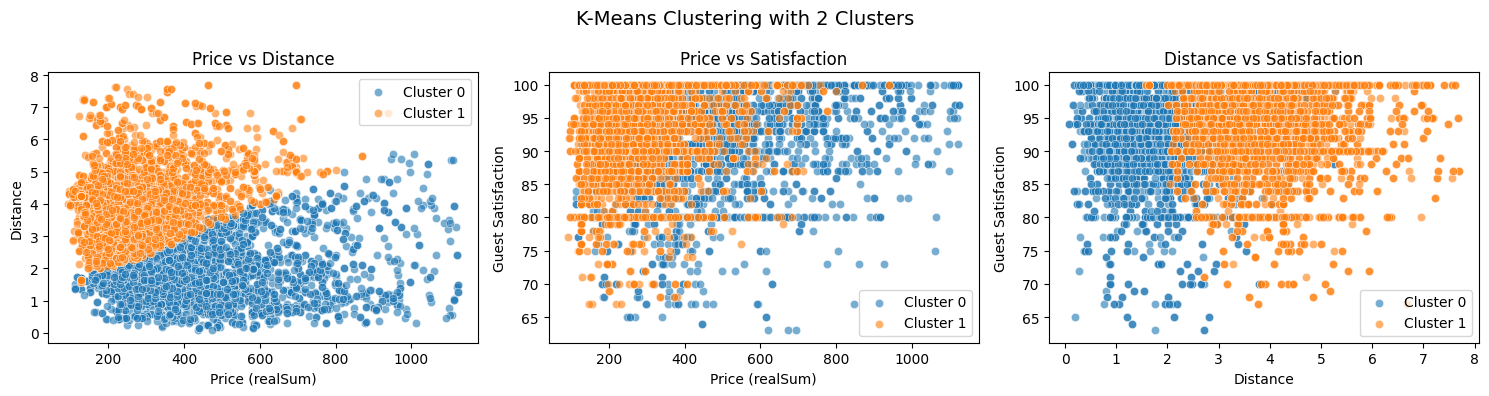

In [360]:
visualize_clusters(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters')

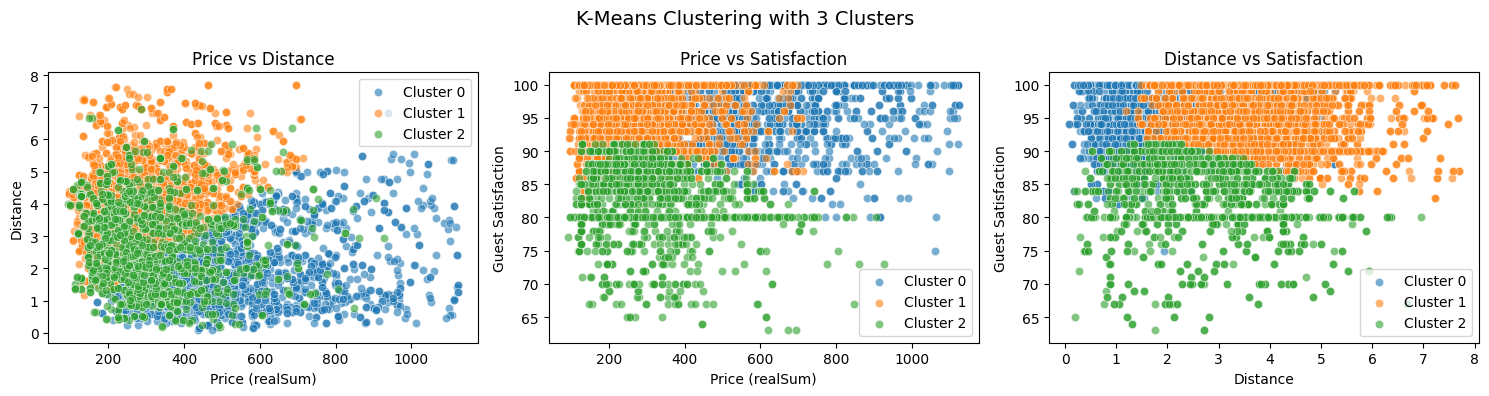

In [361]:
visualize_clusters(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters')

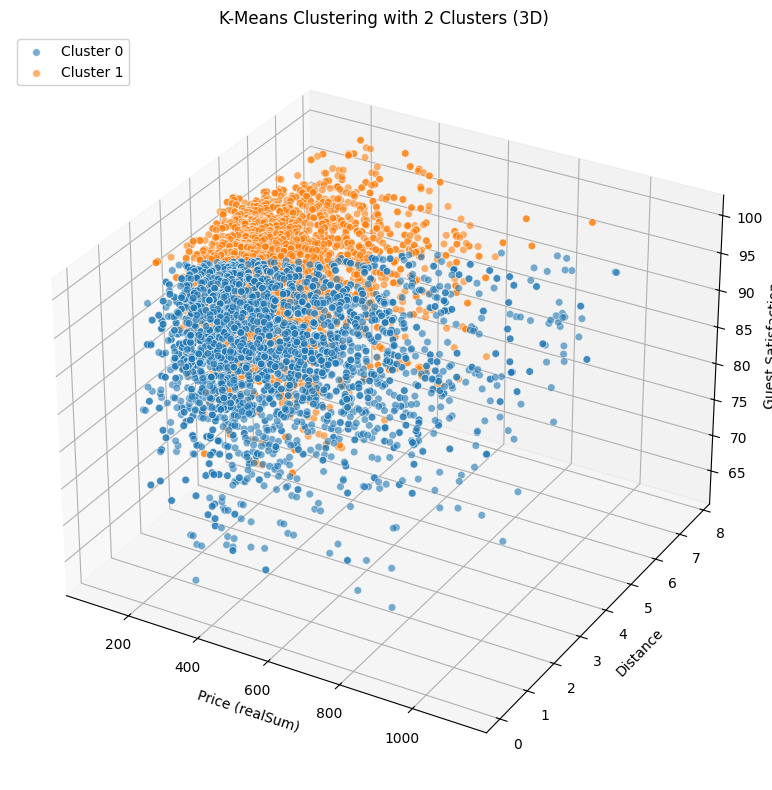

In [362]:
visualize_clusters_3d(paris_all_clean, 'cluster_2', 'K-Means Clustering with 2 Clusters (3D)')

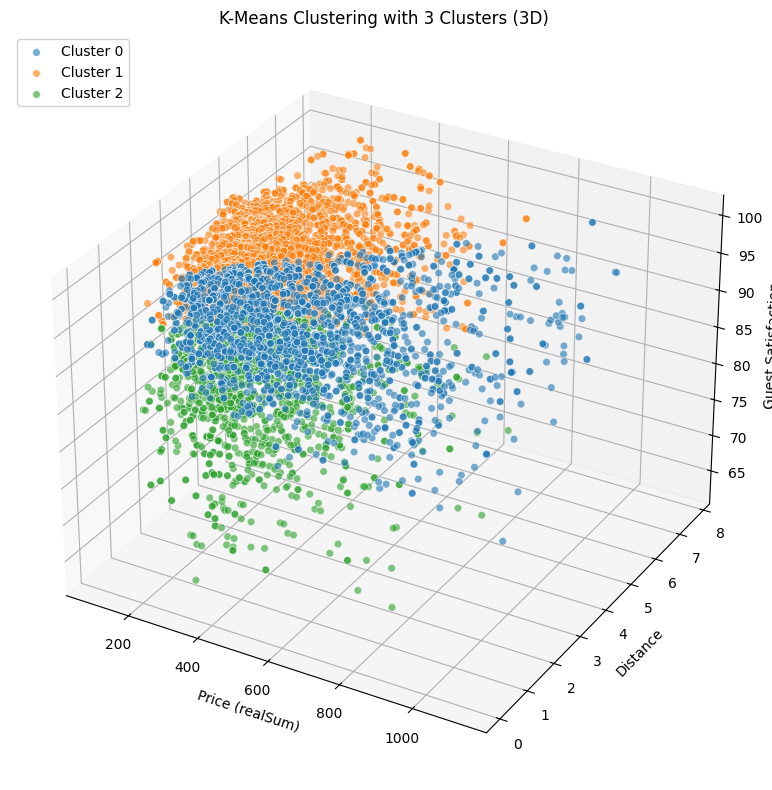

In [363]:
visualize_clusters_3d(paris_all_clean, 'cluster_3', 'K-Means Clustering with 3 Clusters (3D)')
